# Calculating Utilizations for Plates and Plotting with `PyVista`


We will calculate deflections, strains, internal forces, stresses and utilizations for a Mindlin plate. We are also going to visualize the stresses using PyVista and save the results to disk.


In [2]:
# geometry
length_X, length_Y = (600.0, 800.0)
thickness = 25.0

# material properties
young_modulus = 2890.0
poisson_ratio = 0.2
yield_strength = 2.0

# solution parameters
number_of_modes_X = 20
number_of_modes_Y = 20

# concentrated load
load_position = "(300.0, 400.0)"
load_value = "(-100, 0, 0)"

file_name = "_00000000000000001"


These will get populated incrementally.

In [3]:
output_json_file_contents = {"input" : {}, "output" : {}}
input_parameters = {}

The followng block performs a linear static analysis on a Uflyand-Mindlin plate with the following specifications:
- The displacements respect the assumptions implied by the basis functions. 
- The mterial is a simple linear elastic one, with ony layer.
- The load is one concentrated load.
  
The accuracy of the solution can be improved by increasing the values of ``nx`` and ``ny``. Of course, the higher these numbers, the higher the number of computations. The other thing effecting the time required for the block to run is the number of evaluation points. By default, it is derived directly from ``nx``  and ``ny``, but it can be lowered to cut corners or increased for a smoother display. In the latter case, a simpler fitting function might do the job, while if you have to few points, the fit function will be disfunctional.

In [4]:
import ast
import numpy as np

from sigmaepsilon.math.linalg import ReferenceFrame

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.solid.material import (

    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix
from sigmaepsilon.solid.fourier import (
    NavierPlate,
    LoadGroup,
    PointLoad,
)

if isinstance(load_value, str):
    load_value = ast.literal_eval(load_value)
if isinstance(load_position, str):
    load_position = ast.literal_eval(load_position)
load_position = np.array(load_position)
load_value = np.array(load_value)

# set up loads
loads = LoadGroup(LC=PointLoad(load_position, load_value))

# setting up hooke's law
hooke = elastic_stiffness_matrix(E=young_modulus, NU=poisson_ratio)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)
failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)
material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

# section stiffness
section = Section(
    layers=[
        Section.Layer(material=material, thickness=thickness),
    ]
)
ABDS_matrix = section.elastic_stiffness_matrix()
bending_stiffness, shear_stiffness = (
    np.ascontiguousarray(ABDS_matrix[:3, :3]),
    np.ascontiguousarray(ABDS_matrix[3:, 3:]),
)

# nx, ny = (240, 320)  # for higher resolution
# increase these numbers to improve on the accuracy.
nx, ny = (150, 200)
x = np.linspace(0, length_X, nx)
y = np.linspace(0, length_Y, ny)
xv, yv = np.meshgrid(x, y)
evaluation_points = np.stack((xv.flatten(), yv.flatten()), axis=1)

plate = NavierPlate(
    (length_X, length_Y),
    (number_of_modes_X, number_of_modes_Y),
    D=bending_stiffness,
    S=shear_stiffness,
)

results = plate.linear_static_analysis(evaluation_points, loads)

We gather all the parameters affecting the model.

In [5]:
# register input parameters
input_parameters["load_position"] = load_position.tolist()
input_parameters["load_value"] = load_value.tolist()
input_parameters["length_X"] = length_X
input_parameters["length_Y"] = length_Y
input_parameters["thickness"] = thickness
input_parameters["young_modulus"] = young_modulus
input_parameters["poisson_ratio"] = poisson_ratio
input_parameters["yield_strength"] = yield_strength
input_parameters["number_of_modes_X"] = number_of_modes_X
input_parameters["number_of_modes_Y"] = number_of_modes_Y
input_parameters["grid_data"] = {
    "nx" : nx,
    "ny" : ny,
}
input_parameters["stifness"] = {
    "D" : bending_stiffness.tolist(),
    "S" : shear_stiffness.tolist(),
}

## Plotting as a PointCloud with `PyVista`


In [6]:
import pyvista as pv

load_case_results = results["LC"].values
strains = results["LC"].strains
z = np.linspace(-thickness / 2, thickness / 2, 20)
rng = (-thickness / 2, thickness / 2)
util, util_coords = section.utilization(
    strains=strains, rng=rng, z=z, coords=evaluation_points, return_coords=True
)

num_XY, num_Z = util_coords.shape[:2]
util_coords = util_coords.reshape((num_XY * num_Z, 3))
util = util.values.flatten()

point_cloud = pv.PolyData(util_coords)
point_cloud["scalars"] = util

point_cloud

PolyData (0x322983fa0)
  N Cells:    600000
  N Points:   600000
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -1.250e+01, 1.250e+01
  N Arrays:   1

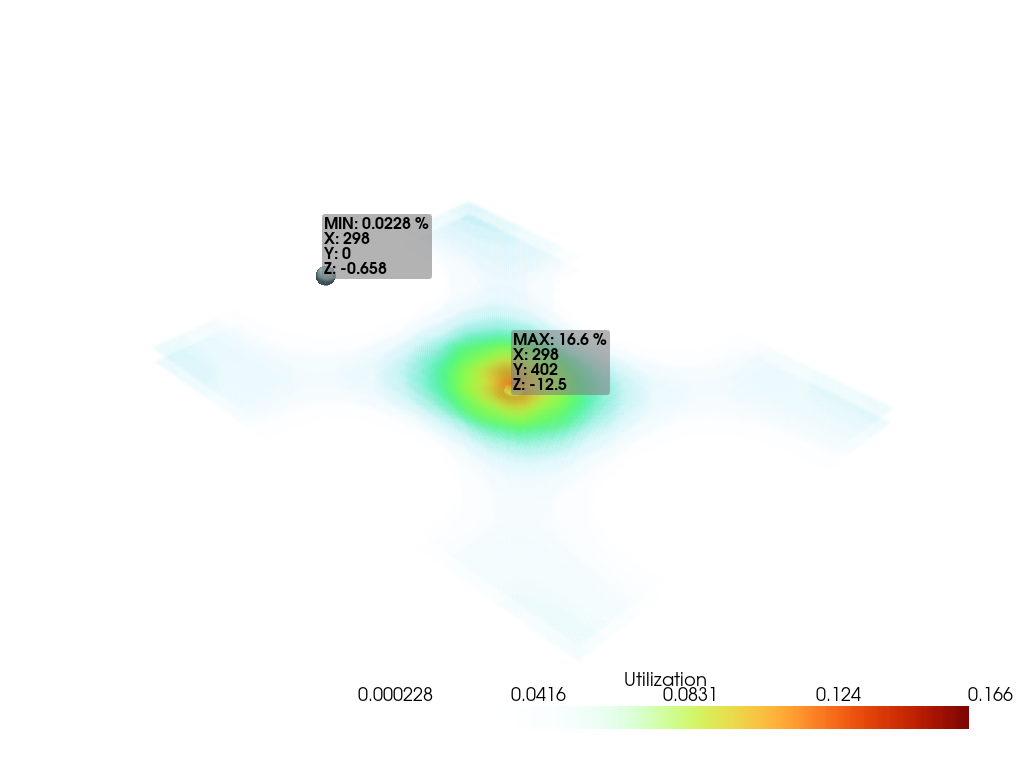

In [7]:
from sigmaepsilon.core.formatting import floatformatter

formatter = floatformatter(sig=3)  # to format strings to 3 significant digits

plotter = pv.Plotter(notebook=True)

scalars = util
points = util_coords
max_index = np.argmax(scalars)
min_index = np.argmin(scalars)

p_min = point_cloud.points[min_index]
p_max = point_cloud.points[max_index]
label_coords = np.array([p_min, p_max])

labels = [
    (
        f"MIN: {formatter.format(util.min()*100)} %"
        f"\nX: {formatter.format(points[min_index, 0])}"
        f"\nY: {formatter.format(points[min_index, 1])}"
        f"\nZ: {formatter.format(points[min_index, 2])}"
    ),
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {formatter.format(points[max_index, 0])}"
        f"\nY: {formatter.format(points[max_index, 1])}"
        f"\nZ: {formatter.format(points[max_index, 2])}"
    ),
]

plotter.add_mesh(
    point_cloud,
    scalars="scalars",
    cmap="turbo",
    lighting=False,
    scalar_bar_args={"title": "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(
    label_coords,
    labels,
    point_size=20,
    font_size=16,
    always_visible=True,
    shape_color="grey",
    shape_opacity=0.6,
    render_points_as_spheres=True,
)

plotter.show(jupyter_backend="static")

In [8]:
from sigmaepsilon.mesh import PointData

res2d_parquet_file_path = file_name + "_res2d" + ".parquet"
pd = PointData(evaluation_points, results=results["LC"].values)
pd.to_parquet(res2d_parquet_file_path)

res3d_parquet_file_path = file_name + "_res3d" + ".parquet"
pd = PointData(util_coords, util=util)
pd.to_parquet(res3d_parquet_file_path)

print("Files saved to destination!")

ImportError: to use ak.to_parquet, you must install pyarrow:

    pip install pyarrow

or

    conda install -c conda-forge pyarrow


# Store results

Store parameters governing execution of the notebook and write to file.

In [ ]:
import json

output_json_file_contents["input"] = input_parameters
output_json_file_contents["output"]["res3d"] = res3d_parquet_file_path
output_json_file_contents["output"]["res2d"] = res2d_parquet_file_path


json.dump(output_json_file_contents, open(file_name + ".json", "w"))

NameError: name 'input_parameters' is not defined